In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import mlbfgs
import slim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device: {device}')
res_scale = .1

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 24).double()
        self.hidden_layer2 = nn.Linear(24, 24).double()
        self.hidden_layer3 = nn.Linear(1, 13).double()
        self.hidden_layer4 = nn.Linear(24, 13).double()

        self.hidden_layer5 = nn.Linear(13, 13).double()
        self.hidden_layer6 = nn.Linear(13, 13).double()
        self.hidden_layer7 = nn.Linear(13, 7).double()
        self.hidden_layer8 = nn.Linear(13, 7).double()

        self.hidden_layer9 = nn.Linear(7, 7).double()
        self.hidden_layer10 = nn.Linear(7, 7).double()
        self.hidden_layer11 = nn.Linear(7, 1).double()
        self.hidden_layer12 = nn.Linear(7, 1).double()
    
        
    def forward(self, y):
        res = torch.sin(self.hidden_layer1(y))
        res = torch.tanh(self.hidden_layer2(res))
        y = self.hidden_layer3(y) + res_scale * self.hidden_layer4(res)

        res = torch.sin(self.hidden_layer5(y))
        res = torch.tanh(self.hidden_layer6(res))
        y = self.hidden_layer7(y) + res_scale * self.hidden_layer8(res)

        res = torch.sin(self.hidden_layer9(y))
        res = torch.tanh(self.hidden_layer10(res))
        y = self.hidden_layer11(y) + res_scale * self.hidden_layer12(res)
        return y
    
    def U(self, y):
        return (self(y) - self(-y)) / 2

    def get_lam(self):
        y = torch.linspace(1,2,10,dtype=torch.float64).view(-1,1).to(device)
        y.requires_grad = True
        U = self.U(y)
        U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
        U_yy = torch.autograd.grad(U_y, y, grad_outputs=torch.ones_like(U_y), create_graph=True)[0]
        return torch.mean(torch.divide(-(1 + U_y) * U_y - (U + y) * U_yy, y * U_yy))
        # return torch.mean(torch.divide((y + U) * U_y,U - y * U_y))
    def get_fixed_lam(self):
        return .4
    
def f(y,U,U_y,lam):
    return -lam * U + ((1 + lam) * y + U) * U_y

def compute_derivative(f, y, model, lam, orders,finite=False):
    y.requires_grad = True
    U = model.U(y)
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    lam = model.get_lam()
    f_val = f(y, U, U_y, lam)
    h = y[1] - y[0]
    res = []
    if not finite:
        for _ in range(int(orders.max())):
            f_val = torch.autograd.grad(f_val, y, grad_outputs=torch.ones_like(f_val), create_graph=True)[0]
            if _ + 1 in orders:
                res.append(f_val)
    else:
        for _ in range(int(orders.max())):
            f_val = (y[1:] - y[:-1]) / h
            if _ + 1 in orders:
                res.append(f_val)
    return res

# @torch.compile
def Loss(model, y, collocation_points,mode,step):
    y.requires_grad = True
    U = model.U(y)
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    # U_yy = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True,retain_graph=)[0]
    if mode == 'fixed':
        lam = model.get_fixed_lam()
    if mode == 'learned':
        lam = model.get_lam()


    # Equation loss
    f_val = f(y, U, U_y,lam)

    # Smooth loss 3rd and fifth derivative
    derivatives = compute_derivative(f,collocation_points,model,lam, orders=np.array([3.0]),finite=True)
    f_yyy = derivatives[0]
    #f_yyyyy = derivatives[1]
 

    # Condition loss U(-2) = 1
    g = model.U(torch.tensor([-2.0], dtype=y.dtype, device=y.device)) - 1
    
    equation_loss = torch.mean(f_val**2)
    condition_loss = torch.mean(g**2)

   # experiment_loss = torch.exp(torch.tensor(data=[-0.5],dtype=torch.float64) * step + torch.tensor(data=[1],dtype=torch.float64)) * torch.mean(U_y**2)
    total_loss = equation_loss + condition_loss + 1e-3*torch.mean(f_yyy**2) #+ 1e-10*torch.mean(f_yyyyy**2) 
    return total_loss



Using device: cpu


### Fixed lambda 

In [6]:
model = PINN().to(device)
model = torch.compile(model)
# optimizer = mlbfgs.LBFGSOptimizer(
#     model_parameters=model.parameters(),
#     lr = .05,              
#     momentum=0.9,       
#     weight_decay=0.0,    
#     rho_min=0.0001,
#     mm_p=0.9,
#     mm_g=0.99,
#     update_freq=100,      
#     hist_sz=100,
#     decay_period=10,
#     damping=0.2,         
#     kl_clip=0.005         
# )
optimizer = slim.SlimQN(
    model_parameters=model.parameters(),
    lr = .01,              
    momentum=0.9,       
    weight_decay=0.0,    
    rho_min=0.0001,
    mm_p=0.9,
    mm_g=0.99,
    update_freq=100,      
    hist_sz=100,
    decay_period=10,
    damping=0.2,         
    kl_clip=0.005         
)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

'''
 Load the model if needed
'''
# model.load_state_dict(torch.load('model.pth'))
# optimizer.load_state_dict(torch.load('optimizer.pth'))
# model.eval()  
# model.train()  

num_epochs = 100000
y_data = torch.linspace(1,3,1000,dtype=torch.float64).view(-1,1).to(device)
# y_data = (y_data-y_data.mean()) / y_data.std()

# writer = SummaryWriter()
Ns = 1000
collocation_points = torch.FloatTensor(Ns).uniform_(-1, 1).view(-1, 1).double().to(device)
collocation_points = (collocation_points-collocation_points.mean()) / collocation_points.std()

def closure(step):
    optimizer.zero_grad() # Clear the gradients
    loss = Loss(model, y_data,collocation_points,'fixed',step) # Compute the loss
    loss.backward() # Backward pass
    return loss

for epoch in range(num_epochs):
    # y_data = torch.FloatTensor(10000).uniform_(-2, 2).view(-1, 1).to(device)

    optimizer.zero_grad()
    loss = Loss(model, y_data, collocation_points,'fixed',epoch)
    loss.backward()
    optimizer.step()#lambda:closure(epoch)
    if epoch % 1000 == 0:
        print(f'epoch {epoch} loss {loss.item()}') 
    # writer.add_scalar(f'Training Loss_1', loss.item(), epoch)
    # if loss.item() <= 1e-8:
    #     break

[SLIM] initialize SlimQN optimizer:
-------------------------------------
	Initial learning rate: 0.01
	Momentum for update: 0.9
	Weight decay: 0.0
	Damping factor: 0.2
	Momentum for param: 0.9
	Momentum for grad: 0.99
	History vector size: 100
	Base Hessian update frequency: 100
	Gradient clipping: 0.005
	Number of threads: 16
-------------------------------------
epoch 0 loss 2.433058331726961
epoch 1000 loss 1.544398870765756
epoch 2000 loss 1.544373576409849
epoch 3000 loss 1.5443733951030751
epoch 4000 loss 1.544373262722467
epoch 5000 loss 1.544373154836492
epoch 6000 loss 1.5443730623186231
epoch 7000 loss 1.544372980552164
epoch 8000 loss 1.544372907005864
epoch 9000 loss 1.5443728401539378
epoch 10000 loss 1.5443727789826593
epoch 11000 loss 1.5443727227576574
epoch 12000 loss 1.544372670909694
epoch 13000 loss 1.5443726229757555
epoch 14000 loss 1.5443725785667899
epoch 15000 loss 1.5443725373487835
epoch 16000 loss 1.544372499030815
epoch 17000 loss 1.5443724633569604
epoch 

### Lambda learned in the process

In [25]:
optimizer = mlbfgs.LBFGSOptimizer(
    model_parameters=model.parameters(),
    lr = .01,              
    momentum=0.9,       
    weight_decay=0.0,    
    rho_min=0.0001,
    mm_p=0.9,
    mm_g=0.99,
    update_freq=100,      
    hist_sz=100,
    decay_period=10,
    damping=0.2,         
    kl_clip=0.005         
)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

num_epochs = 100000
y_data = torch.linspace(1,2,10000,dtype=torch.float64).view(-1,1).to(device)
# y_data = (y_data-y_data.mean()) / y_data.std()

# writer = SummaryWriter()
Ns = 100
collocation_points = torch.FloatTensor(Ns).uniform_(-1, 1).view(-1, 1).double().to(device)
collocation_points = (collocation_points-collocation_points.mean()) / collocation_points.std()

def closure(step):
    optimizer.zero_grad() # Clear the gradients
    loss = Loss(model, y_data,collocation_points,'learned',step) # Compute the loss
    loss.backward() # Backward pass
    return loss

for epoch in range(num_epochs):
    # y_data = torch.FloatTensor(10000).uniform_(-2, 2).view(-1, 1).to(device)

    optimizer.zero_grad()
    loss = Loss(model, y_data, collocation_points,'learned',epoch)
    loss.backward()
    optimizer.step()#lambda:closure(epoch)
    if epoch % 1000 == 0:
        print(f'epoch {epoch} loss {loss.item()}') 
    # writer.add_scalar(f'Training Loss_1', loss.item(), epoch)
    if loss.item() <= 1e-8:
        break

[LBFGS] initialize LBFGS optimizer:
-------------------------------------
Initial learning rate: 0.01
Momentum for update: 0.9
Weight decay: 0.0
Damping factor: 0.2
Momentum for param: 0.9
Momentum for grad: 0.99
Decay period: 10
History vector size: 100
Base Hessian update frequency: 100
Number of threads: 16
-------------------------------------
epoch 0 loss 0.0008252051036639459
epoch 1000 loss 0.0008046722073594323
epoch 2000 loss 0.0008045861120721289
epoch 3000 loss 0.0008045608881096074
epoch 4000 loss 0.0008045532654871674
epoch 5000 loss 0.0008045506186274913
epoch 6000 loss 0.0008045493623075105
epoch 7000 loss 0.0008045484927485156
epoch 8000 loss 0.0008045477309473993
epoch 9000 loss 0.0008045469996343502
epoch 10000 loss 0.0008045462774453345
epoch 11000 loss 0.0008045455584768527
epoch 12000 loss 0.0008045448410971026
epoch 13000 loss 0.0008045441248542327
epoch 14000 loss 0.0008045434096223575


KeyboardInterrupt: 

Inferred lambda is 0.41960668363630077
Residual is 0.03779150472319265


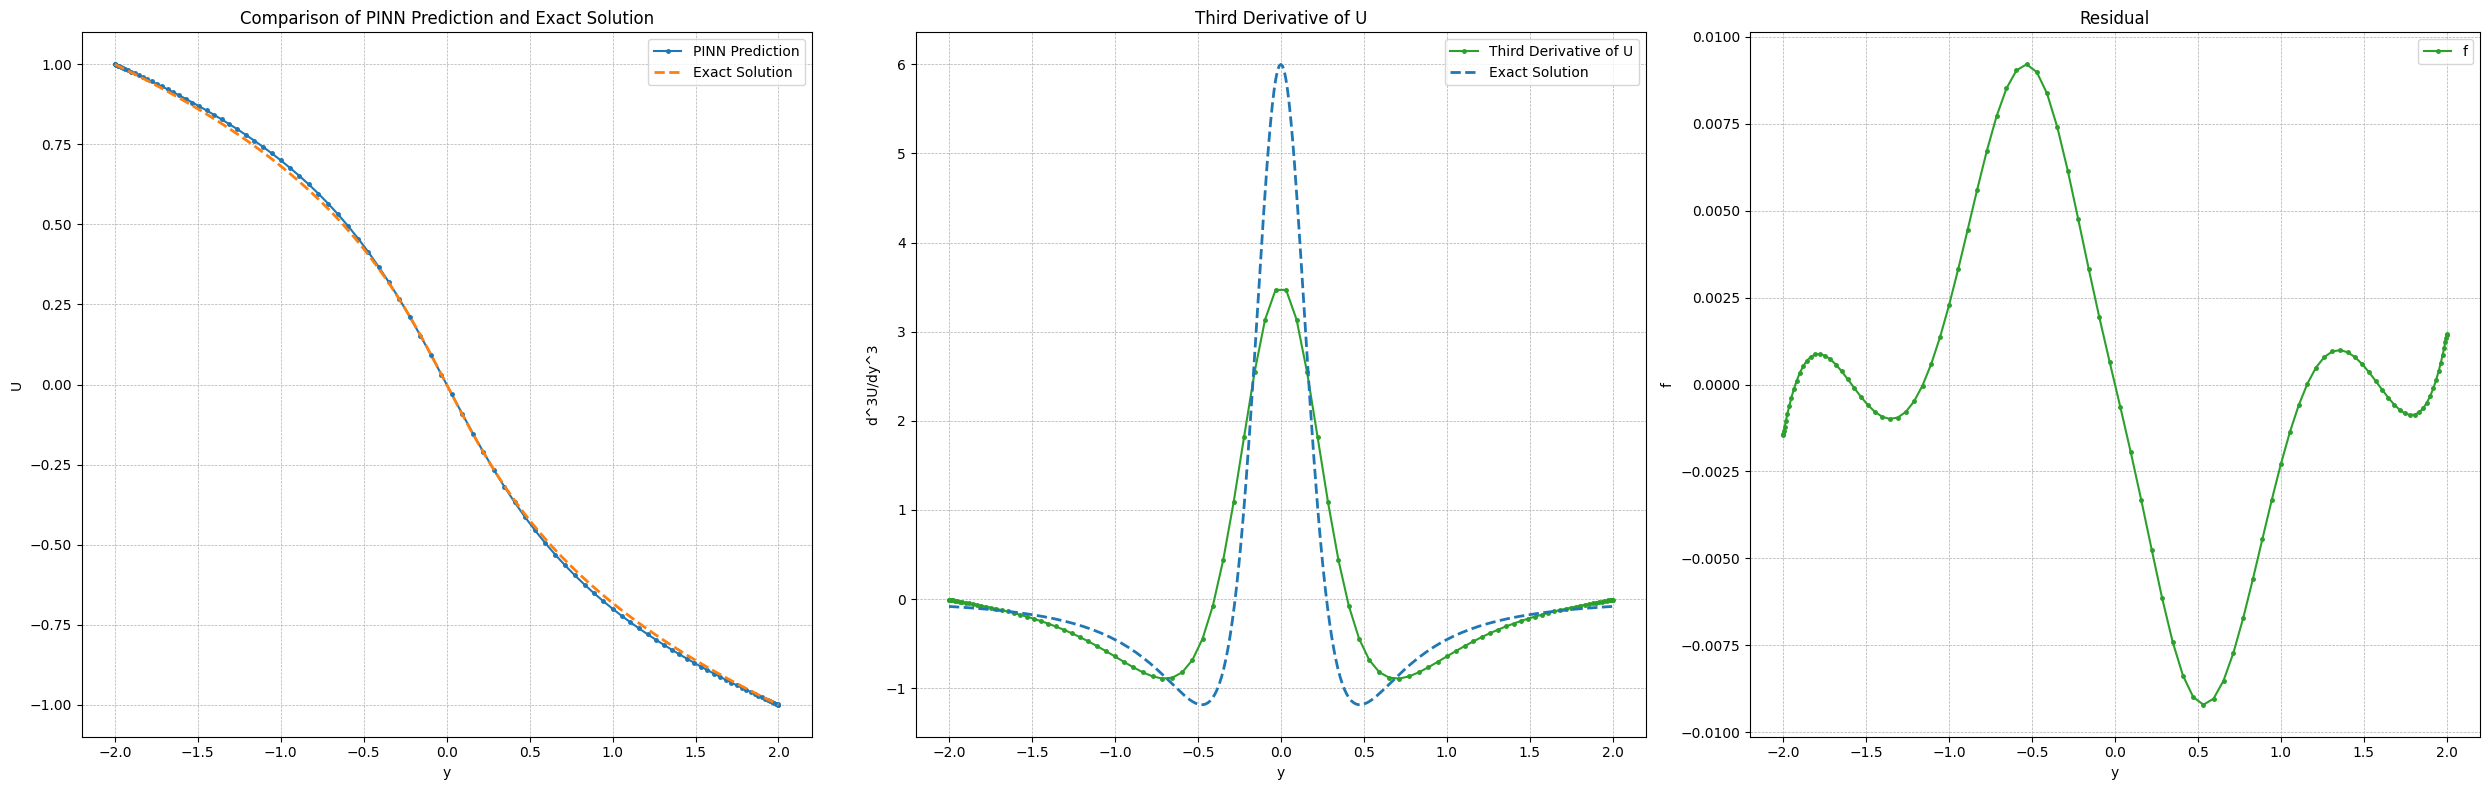

In [27]:
y_test = 2*torch.sin(torch.linspace(-np.pi/2, np.pi/2, 100)).view(-1, 1).double().to(device)
y_test.requires_grad = True
# Get model predictions and detach to move to CPU
U_pred = model.U(y_test)
U_pred_y = torch.autograd.grad(U_pred, y_test, grad_outputs=torch.ones_like(U_pred), create_graph=True)[0]
U_pred_yy = torch.autograd.grad(U_pred_y, y_test, grad_outputs=torch.ones_like(U_pred_y), create_graph=True)[0]
U_pred_yyy = torch.autograd.grad(U_pred_yy, y_test, grad_outputs=torch.ones_like(U_pred_yy), create_graph=True)[0]
U_pred_yyyy = torch.autograd.grad(U_pred_yyy, y_test, grad_outputs=torch.ones_like(U_pred_yyy), create_graph=True)[0]
U_pred_yyyyy = torch.autograd.grad(U_pred_yyyy, y_test, grad_outputs=torch.ones_like(U_pred_yyyy), create_graph=True)[0]

lam = model.get_lam()#.detach().cpu().numpy()
print(f'Inferred lambda is {lam}')
residual = f(y_test,U_pred,U_pred_y,lam)
print(f'Residual is {torch.sqrt(torch.sum(residual**2))}')
U_pred = U_pred.detach().cpu().numpy()
# Generate exact solution using implicit formula
U_values = torch.linspace(0, 1, 100, dtype=torch.float64, requires_grad=True)

y = -U_values - U_values**(1 + 1/.5)

y_u = torch.autograd.grad(y, U_values, grad_outputs=torch.ones_like(y), create_graph=True)[0]
y_uu = torch.autograd.grad(y_u, U_values, grad_outputs=torch.ones_like(y_u), create_graph=True)[0]
y_uuu = torch.autograd.grad(y_uu, U_values, grad_outputs=torch.ones_like(y_uu), create_graph=True)[0]



u_yyy = (3 * (y_uu)**2 - y_u * y_uuu) / y_u**5

# Convert to np
y_test_np = y_test.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()
y_full_np = np.concatenate([y_np,-y_np])
y_full_np_arg = y_full_np.argsort()
y_full_np = y_full_np[y_full_np_arg]
u_np = U_values.detach().cpu().numpy()
u_full_np = np.concatenate([u_np,-u_np])
u_full_np = u_full_np[y_full_np_arg]

u_yyy_np = u_yyy.detach().cpu().numpy()
u_yyy_full_np = np.concatenate([u_yyy_np , u_yyy_np])[y_full_np_arg]

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

# Plot the PINN Prediction vs Exact Solution
ax1.plot(y_test_np, U_pred, '.-', label='PINN Prediction', color='#1f77b4', markersize=5)
ax1.plot(y_full_np, u_full_np, label='Exact Solution', color='#ff7f0e', linestyle='--', linewidth=2)
ax1.set_title('Comparison of PINN Prediction and Exact Solution')
ax1.set_xlabel('y')
ax1.set_ylabel('U')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Plot the third derivative
ax2.plot(y_test_np, U_pred_yyy.detach().cpu().numpy(), '.-', label='Third Derivative of U', color='#2ca02c', markersize=5)
ax2.plot(y_full_np, u_yyy_full_np, label='Exact Solution', linestyle='--', linewidth=2)

ax2.set_title('Third Derivative of U')
ax2.set_xlabel('y')
ax2.set_ylabel('d^3U/dy^3')
ax2.grid(True, which='both', linestyle='--', linewidth=0.51)
ax2.legend()

# Plot the residual 
ax3.plot(y_test_np, residual.detach().cpu().numpy(), '.-', label='f', color='#2ca02c', markersize=5)

ax3.set_title('Residual')
ax3.set_xlabel('y')
ax3.set_ylabel('f')
ax3.grid(True, which='both', linestyle='--', linewidth=0.51)
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model 
model_path = 'model_nbatch_first.pth'
optimizer_path = 'optimizer_nbatch_first.pth'

torch.save(model.state_dict(), model_path)

torch.save(optimizer.state_dict(), optimizer_path)